In [73]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from random import seed
tf.compat.v1.disable_eager_execution()

In [74]:
seed(123)

In [75]:
#!pip install adversarial-robustness-toolbox

In [76]:
from art.attacks.inference import model_inversion 
from art.estimators.classification import KerasClassifier
from art.defences.postprocessor import GaussianNoise

In [77]:
def load_mnist():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing MNIST digit dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # convolutional layers expect images to have 3 dimensions (width, height, depth)
  # in color images the depth is 3 for the RGB channels
  # MNIST is grayscale and hence originally does not need a third dimension
  # so we need to artificially add it
  train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
  test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)
  return train_data, train_labels, test_data, test_labels
 
def make_model():
  """ Define a Keras model"""
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16, 8,
                              strides=2,
                              padding='same',
                              activation='relu',
                              input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Conv2D(32, 4,
                              strides=2,
                              padding='valid',
                              activation='relu'),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  return model

In [78]:
train_data, train_labels, test_data, test_labels = load_mnist()

In [79]:
# make the neural network model with the function specified above. then look at it
model = make_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        1040      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 32)          8224      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [80]:
# specify hyperparameters
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Model Inversion Attack

A model inversion attack is a type of machine learning attack that targets the privacy of a trained machine learning model. It works by exploiting information that is leaked through the model's predictions to infer sensitive information about the training data that was used to train the model.

To perform a model inversion attack, an attacker first generates a set of input data points and submits them to the target model. The attacker then observes the model's output and uses this output to infer sensitive information about the training data. This process is repeated until the attacker has inferred as much sensitive information as possible.

The success of a model inversion attack depends on several factors, including the accuracy of the model, the amount of information that is leaked through the model's predictions, and the availability of training data that is similar to the target data. In some cases, an attacker may need to use additional techniques, such as adversarial attacks, to increase the accuracy of the inferred data.

There are several defenses against model inversion attacks, including limiting access to the trained model, adding noise to the model's output, and limiting the amount of information that is exposed through the model's predictions. Additionally, machine learning models can be trained using privacy-preserving techniques, such as differential privacy or federated learning, which help to prevent sensitive information from being leaked during training.

In [81]:
GN01 = GaussianNoise(0.01)
GN02 = GaussianNoise(0.1)
# convert keras model to ART model
classifier = KerasClassifier(model=model,
                             clip_values=(0, 1), 
                             use_logits=False
                            )
classifier01 = KerasClassifier(model=model,
                             clip_values=(0, 1), 
                             use_logits=False, 
                             postprocessing_defences=GN01
                            )
classifier02 = KerasClassifier(model=model,
                             clip_values=(0, 1), 
                             use_logits=False, 
                             postprocessing_defences=GN02
                            )

In [82]:
# train the model
classifier.fit(train_data, train_labels, batch_size=264, nb_epochs=10)
classifier01.fit(train_data, train_labels, batch_size=264, nb_epochs=10)
classifier02.fit(train_data, train_labels, batch_size=264, nb_epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 508us/sample - loss: 0.5686 - accuracy: 0.8207
Epoch 2/10
60000/60000 [==============================] - 30s 506us/sample - loss: 0.1234 - accuracy: 0.9618
Epoch 3/10
60000/60000 [==============================] - 32s 531us/sample - loss: 0.0877 - accuracy: 0.9726
Epoch 4/10
60000/60000 [==============================] - 33s 547us/sample - loss: 0.0709 - accuracy: 0.9779
Epoch 5/10
60000/60000 [==============================] - 33s 558us/sample - loss: 0.0624 - accuracy: 0.9805
Epoch 6/10
60000/60000 [==============================] - 33s 543us/sample - loss: 0.0530 - accuracy: 0.9832
Epoch 7/10
60000/60000 [==============================] - 32s 532us/sample - loss: 0.1504 - accuracy: 0.9598
Epoch 8/10
60000/60000 [==============================] - 35s 585us/sample - loss: 0.0536 - accuracy: 0.9837
Epoch 9/10
60000/60000 [==============================] - 33s 544us/sample - loss: 0.0452 - accuracy: 0.9

In [83]:
# create the attack object
my_attack = model_inversion.MIFace(classifier)
my_attack01 = model_inversion.MIFace(classifier01)
my_attack02 = model_inversion.MIFace(classifier02)

In [84]:
# create an array of the classes to be attacked
y_all = np.arange(10)
y_all

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [85]:
inferred_images = my_attack.infer(x=None,y=y_all)
inferred_images01 = my_attack01.infer(x=None,y=y_all)
inferred_images02 = my_attack02.infer(x=None,y=y_all)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

No gauss noise


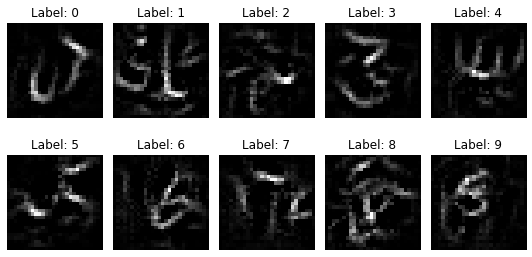

Gauss noise: 0.01


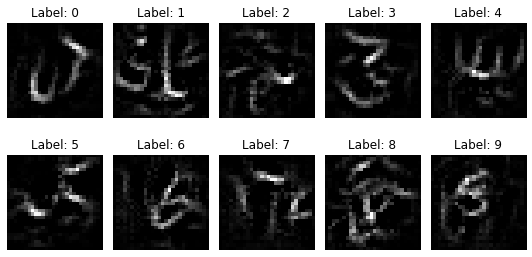

Gauss noise: 0.1


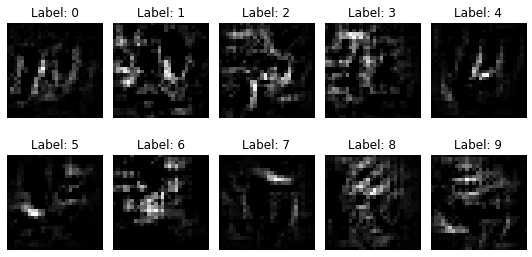

In [86]:
# plot the inverted class representations
def plot_inferred_images( inferredimages):
    num_row = 2
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(10):
        ax = axes[i//num_col, i%num_col]
        ax.set_axis_off()
        ax.imshow(inferredimages[i,:,:,:].reshape(28,28), cmap='gray')
        ax.set_title('Label: {}'.format(y_all[i]))

    plt.tight_layout()
    plt.show()

print("No gauss noise")
plot_inferred_images( inferred_images)
print("Gauss noise: 0.01")
plot_inferred_images( inferred_images01)
print("Gauss noise: 0.1")
plot_inferred_images( inferred_images02)